<a href="https://colab.research.google.com/github/Chacamaqui89/Project-Soubirous/blob/main/Energy_Harvesting_com_for%C3%A7a_impulsiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

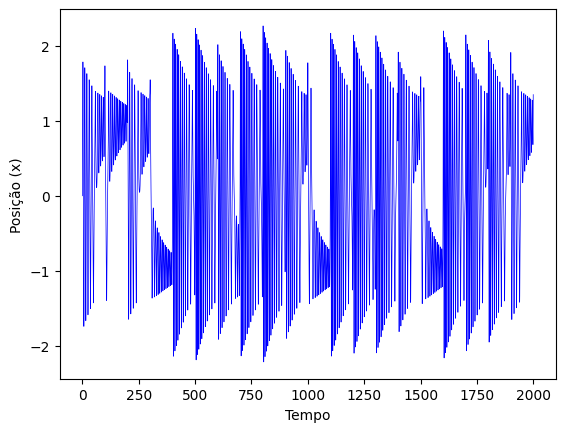

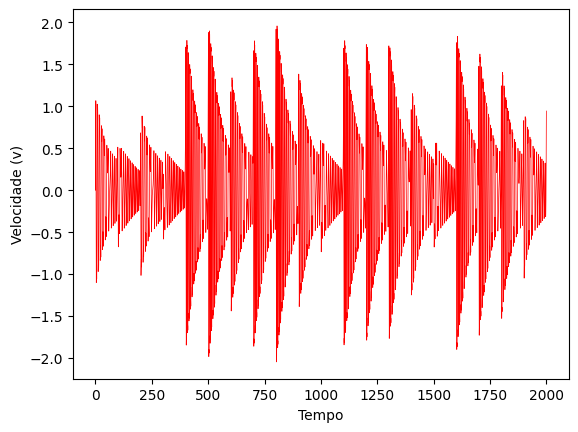

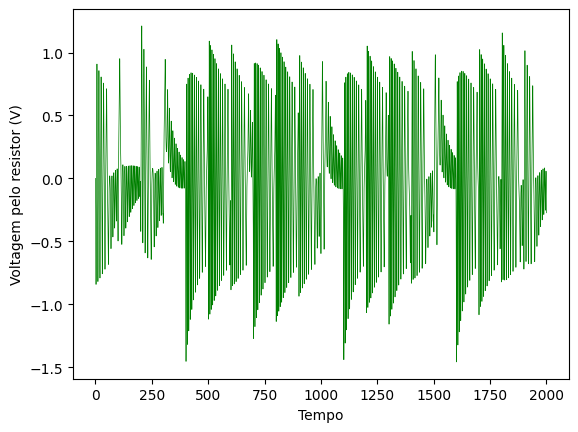

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import pywt

# Parâmetros do sistema
zeta = 0.01
Xi = 0.05
A = 0.9     # agora é a amplitude do pulso
T = 100  # agora é o período T entre pulsos
delta  = 0.05
kappa  = 0.5
sigma  = 0.9     # largura dos pulsos

f=1/T

# Força impulsiva vetorizada (soma de N pulsos gaussianos)
def impulsive_force(t, T, sigma, A, N=1000):
    ns = np.arange(N)
    return np.sum(A * np.exp(-((t - ns * T)**2) / (2 * sigma**2)))

# Equações do sistema 3-variáveis com força impulsiva
def equations(t, y, A):
    x, vx, v = y
    x_dot = vx
    F_imp = impulsive_force(t, T, sigma, A)
    vx_dot = F_imp - 2 * zeta * vx + 0.5 * x * (1 - x**2) + Xi * v
    v_dot = -delta * v - kappa * vx
    return [x_dot, vx_dot, v_dot]

# Condições iniciais
ei = [0, 0, 0]

# Parâmetros de simulação
tf       = 2000
dt       = 0.01
n        = int(tf/dt)
t_analise = np.linspace(0, tf, n)

# Resolve exatamente como antes, sem lambda!
sol = solve_ivp(equations, [0, tf], ei, t_eval = t_analise, args = (A,), method  = 'RK45')

# Agora você já tem x1_t = sol.y[0], etc.
x1_t = sol.y[0]
x2_t = sol.y[1]
x3_t = sol.y[2]

plt.plot(t_analise, x1_t,color = 'blue', linewidth = 0.5)
plt.xlabel('Tempo')
plt.ylabel('Posição (x)')
plt.show()

plt.plot(t_analise, x2_t,color = 'red', linewidth = 0.5)
plt.xlabel('Tempo')
plt.ylabel('Velocidade (v)')
plt.show()

plt.plot(t_analise, x3_t,color = 'green', linewidth = 0.5)
plt.xlabel('Tempo')
plt.ylabel('Voltagem pelo resistor (V)')
plt.show()

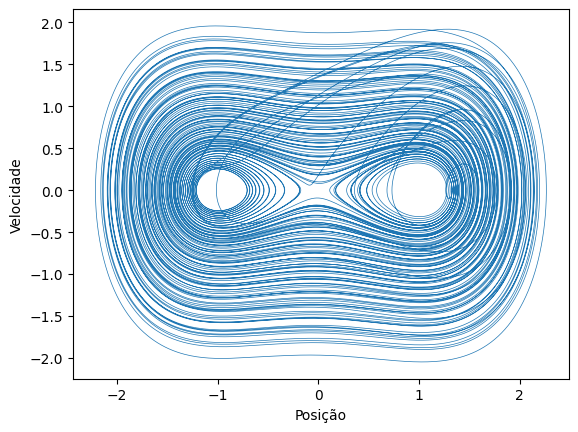

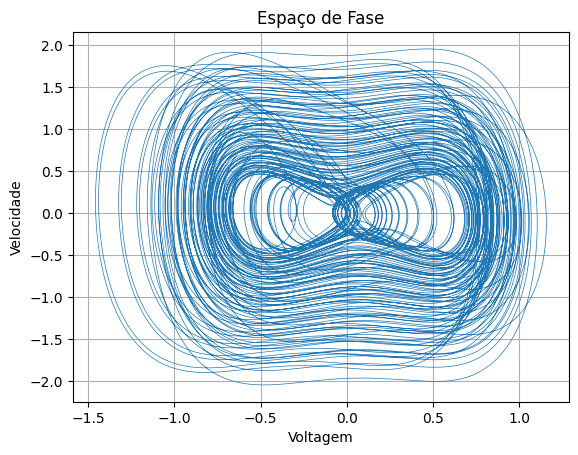

In [4]:
# Espaço de fase

t_transiente = 0.4*tf  # Tempo do transiente a ser descartado
indice_perma = np.where(t_analise >= t_transiente)  # Índice para pegar a parte permanente
t_perma = t_analise[indice_perma]  # Tempo permanente
x1_t_perma = x1_t[indice_perma]  # Posição permanente
x2_t_perma = x2_t[indice_perma]  # Velocidade permanente
x3_t_perma = x3_t[indice_perma]  # Voltagem permanente

# Plotando o espaço de fase

plt.plot(x1_t_perma, x2_t_perma, linewidth = 0.5)
plt.xlabel('Posição')
plt.ylabel('Velocidade')
plt.show()

# Plotando o espaço de fase

plt.plot(x3_t_perma, x2_t_perma, linewidth=0.5)
plt.title("Espaço de Fase")
plt.xlabel("Voltagem")
plt.ylabel("Velocidade")
plt.grid()
plt.show()

In [ ]:
t_periodo     = T
x_poincare    = []
vx_poincare   = []
y_atual       = ei.copy()
n_iteracoes   = 1000
transiente    = int(0.4 * n_iteracoes)

for i in tqdm(range(n_iteracoes), desc=f'Poincaré (A={A:.3f})'):
    sol = solve_ivp(
        fun=lambda t, y: equacoes(t, y, A),
        t_span=[0, t_periodo],
        y0=y_atual,
        method='RK45',
        rtol=1e-10,
        atol=1e-12
    )
    # **atualiza o estado para a próxima iteração**
    y_atual = sol.y[:, -1].tolist()

    # coleta só após descartar as iterações de transiente
    if i >= transiente:
        x_poincare.append(y_atual[0])
        vx_poincare.append(y_atual[1])

plt.figure(figsize=(6, 6))
plt.scatter(x_poincare, vx_poincare, s=0.1, color='red', linewidth=0.5)
plt.title('Mapa de Poincaré Iterativo')
plt.xlabel('Posição x')
plt.ylabel('Velocidade vx')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# --- Configuração para diagrama de bifurcação e mapa de Poincaré ---
A_min, A_max, n_A = 0.05, 1.0, 300
A_values = np.linspace(A_min, A_max, n_A)

# Escolha um valor de A para plotar o mapa de Poincaré
A_map = A_values[n_A // 2]  # valor médio por padrão

# Parâmetros temporais
t_total = 5000.0           # tempo total de simulação
dt = 0.01                  # passo de avaliação
t_eval = np.arange(0, t_total + dt, dt)

# Preparação de listas
A_bif, x_bif = [], []
x_map, vx_map = [], []

# Varredura de A com barra de progresso única
desc = f'Varredura A [{A_min}-{A_max}]'
for A in tqdm(A_values, desc=desc):
    sol = solve_ivp(
        fun=lambda t, y: equacoes(t, y, A),
        t_span=(0, t_total),
        y0=ei,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-6,
        atol=1e-8
    )

    # Instantes de Poincaré
    t_poincare = np.arange(T, t_total, T)
    steady = t_poincare[int(len(t_poincare) * 0.5):]  # descarta transiente

    # Coleta para bifurcação e, se A==A_map, coleta mapa completo
    for tp in steady:
        idx = np.searchsorted(sol.t, tp)
        if idx >= len(sol.t): idx = -1
        A_bif.append(A)
        x_bif.append(sol.y[0, idx])
        if np.isclose(A, A_map, atol=(A_max-A_min)/n_A):
            x_map.append(sol.y[0, idx])
            vx_map.append(sol.y[1, idx])

# --- Plot do diagrama de bifurcação ---
plt.figure(figsize=(10, 6))
plt.scatter(A_bif, x_bif, s=0.5, alpha=0.7)
plt.xlabel('A (amplitude do pulso)')
plt.ylabel('x no mapa de Poincaré')
plt.title('Diagrama de Bifurcação – Sistema 3-variáveis com Força Impulsiva')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot do mapa de Poincaré para A = A_map ---
plt.figure(figsize=(6, 6))
plt.scatter(x_map, vx_map, s=1)
plt.xlabel('x (posição)')
plt.ylabel('vx (velocidade)')
plt.title(f'Mapa de Poincaré (A = {A_map:.3f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Bacia de Atração

# Grade de condições iniciais
x_vals = np.linspace(-2, 2, 100)
v_vals = np.linspace(-2, 2, 100)
X, V = np.meshgrid(x_vals, v_vals)

# Matriz para armazenar os atratores
bacia = np.zeros_like(X)

def classificar_atrator(solucao):
    # Define critérios para diferentes atratores
    x_final = solucao.y[0, -1]
    if x_final > 1:
        return 1  # Atrator positivo
    elif x_final < -1:
        return 2  # Atrator negativo
    else:
        return 3  # Estado caótico ou intermediário

# Simular para cada ponto da grade
for i in tqdm(range(X.shape[0]), desc='Calculando Bacia de Atração'):
    for j in range(X.shape[1]):
        estado_inicial = [X[i, j], V[i, j], 0]
        sol = solve_ivp(equations, [0, tf], ei, t_eval = t_analise, args = (A,), method  = 'RK45')
        bacia[i, j] = classificar_atrator(sol)

# Plotar a bacia de atração
plt.figure(figsize=(8, 6))
plt.contourf(X, V, bacia, levels=3, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Atrator')
plt.xlabel('Posição Inicial')
plt.ylabel('Velocidade Inicial')
plt.title('Bacia de Atração')
plt.show()

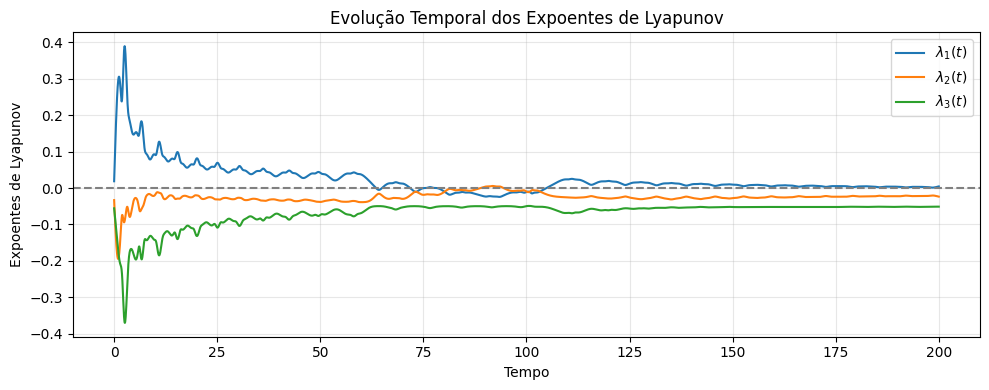

In [17]:
def lyapunov_evolution(equations, ci, t_span, A, dt=0.01):
    n = len(ci)
    t0, tf = t_span
    times = np.arange(t0, tf + dt, dt)
    # estado + matriz tangente inicial (identidade)
    Y = np.hstack([ci, np.eye(n).flatten()])
    lyap = np.zeros((len(times), n))

    def variational(t, Y):
        x = Y[:n]
        M = Y[n:].reshape(n, n)
        # dinâmica original
        dx = np.array(equations(t, x, A))
        # Jacobiana do sistema
        J = np.array([
            [0, 1, 0],
            [(1 - 3 * x[0]**2) / 2, -2 * zeta, Xi],
            [0, -kappa, -delta]
        ])
        dM = J @ M
        return np.hstack([dx, dM.flatten()])

    for i, t in enumerate(times):
        # passo de RK4
        k1 = variational(t, Y)
        k2 = variational(t + dt/2, Y + dt*k1/2)
        k3 = variational(t + dt/2, Y + dt*k2/2)
        k4 = variational(t + dt,   Y + dt*k3)
        Y = Y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

        # QR para ortonormalizar
        M = Y[n:].reshape(n, n)
        Q, R = np.linalg.qr(M)
        local = np.log(np.abs(np.diag(R)) + 1e-12) / dt

        # média cumulativa
        if i == 0:
            lyap[i] = local
        else:
            lyap[i] = (lyap[i-1] * i + local) / (i + 1)

        # reescreve M como Q
        Y[n:] = Q.flatten()

    return times, lyap

# Executa a evolução
times, lyap = lyapunov_evolution(equations, ei, (0, 200), A, dt=0.05)

# Plot corrigido
plt.figure(figsize=(10, 4))
for j in range(lyap.shape[1]):
    plt.plot(times, lyap[:, j], label=f'$\lambda_{j+1}(t)$')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Tempo')
plt.ylabel('Expoentes de Lyapunov')
plt.title('Evolução Temporal dos Expoentes de Lyapunov')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

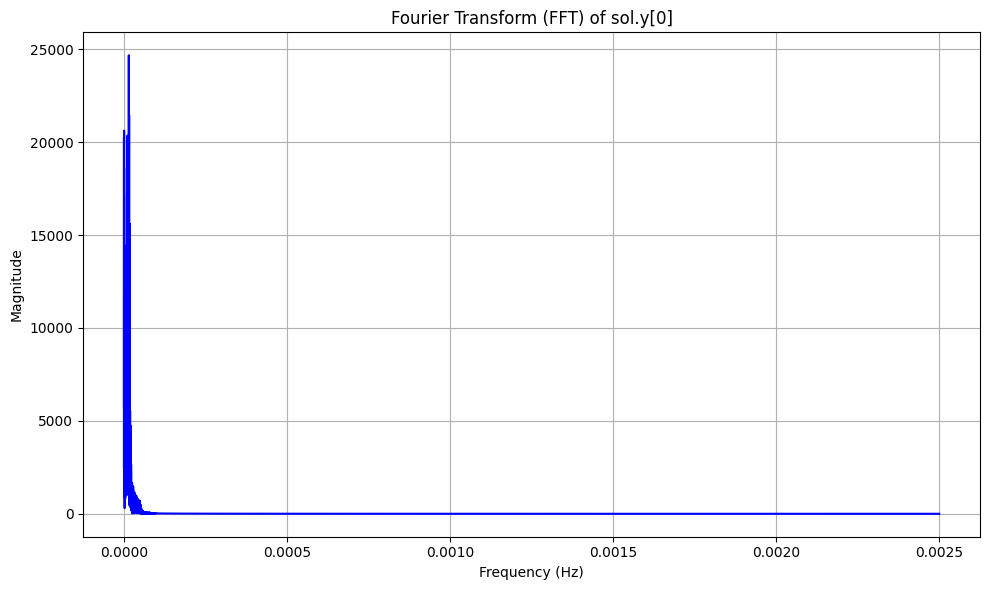

In [31]:
from scipy.fft import fft, fftfreq

# Sinal a ser transformado via FFT
signal_data = sol.y[0, :]

# Número de pontos no sinal
N = len(signal_data)

# Calcular a FFT
fft_values = fft(signal_data)
fft_frequencies = fftfreq(N, 1/f)  # Frequências associadas à FFT

# Plotar o resultado da FFT
plt.figure(figsize=(10, 6))
plt.plot(fft_frequencies[:N//4], np.abs(fft_values[:N//4]), 'b-', linewidth=1.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Fourier Transform (FFT) of sol.y[0]")
plt.grid(True)
plt.tight_layout()
plt.show()

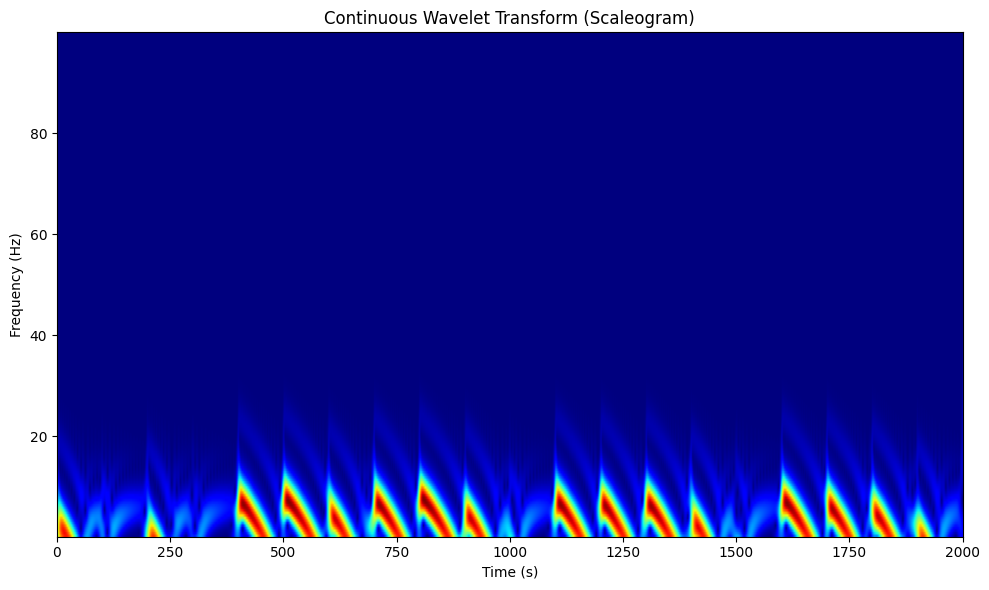

In [23]:
# perform CWT
time=t_analise
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=200)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(sol.y[0], widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# Plotar os resultados da CWT usando imshow
fig, ax = plt.subplots(figsize=(10, 6))

# Usar imshow para plotar o resultado da CWT
# extent define os limites no eixo x (tempo) e eixo y (frequência)
im = ax.imshow(np.abs(cwtmatr), extent=[time[0], time[-1], freqs[-1], freqs[0]],
               aspect='auto', cmap='jet')

#ax.set_yscale("log")  # Definir o eixo y em escala logarítmica
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Continuous Wavelet Transform (Scaleogram)")
#fig.colorbar(im, ax=ax)  # Adicionar barra de cor

plt.tight_layout()
plt.show()